In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [18]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0
        
        block_out_features = out_features // num_blocks
        
        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])
        
    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
        
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        # TODO !!!!
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t) # Всегда <= 1.0
        f = torch.exp(f_tilde + m_prev - m_t) # Всегда <= 1.0

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class sLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev.to(x.device)
        c_prev = c_prev.to(x.device)
        n_prev = n_prev.to(x.device)
        m_prev = m_prev.to(x.device)
        
        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * (v * k) # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class mLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class xLSTM(nn.Module):
    # Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type")
            self.layers.append(layer)

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

In [19]:
torch.manual_seed(42)
np.random.seed(42)

In [20]:
# классификатор на базе xLSTM
class CustomXlstmClassifier(nn.Module):
    def __init__(self, in_features, head_dim, heads, architecture, n_classes, slstm_factor=4/3, mlstm_factor=2):
        super().__init__()
        self.feature_extractor = xLSTM(
            input_size=in_features,
            head_size=head_dim,
            num_heads=heads,
            layers=architecture,
            batch_first=True,
            proj_factor_slstm=slstm_factor,
            proj_factor_mlstm=mlstm_factor
        )
        self.output_layer = nn.Linear(in_features, n_classes)

    def forward(self, input_seq):
        features, _ = self.feature_extractor(input_seq)
        features = features.squeeze(1)
        return self.output_layer(features)


In [21]:
# Подготовка данных
dataset = load_iris()
features = dataset.data
targets = dataset.target

# Масштабирование признаков
normalizer = StandardScaler()
features = normalizer.fit_transform(features)

# Разбиение на обучающую и тестовую выборки
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.2, stratify=targets, random_state=SEED
)

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [22]:
# Инициализация сети
model = CustomXlstmClassifier(
    in_features=4,
    head_dim=8,
    heads=1,
    architecture=['m'],
    n_classes=3,
    mlstm_factor=2
)

Эпоха 100: Train Loss = 0.1406, Test Accuracy = 0.9333
Эпоха 200: Train Loss = 0.0436, Test Accuracy = 0.8000
Эпоха 300: Train Loss = 0.0219, Test Accuracy = 0.9000
Эпоха 400: Train Loss = 0.0103, Test Accuracy = 0.8667
Эпоха 500: Train Loss = 0.0068, Test Accuracy = 0.8667
Эпоха 600: Train Loss = 0.1116, Test Accuracy = 0.9333
Эпоха 700: Train Loss = 0.0116, Test Accuracy = 0.9000
Эпоха 800: Train Loss = 0.0065, Test Accuracy = 0.9333
Эпоха 900: Train Loss = 0.0048, Test Accuracy = 0.9333
Эпоха 1000: Train Loss = 0.0039, Test Accuracy = 0.9000


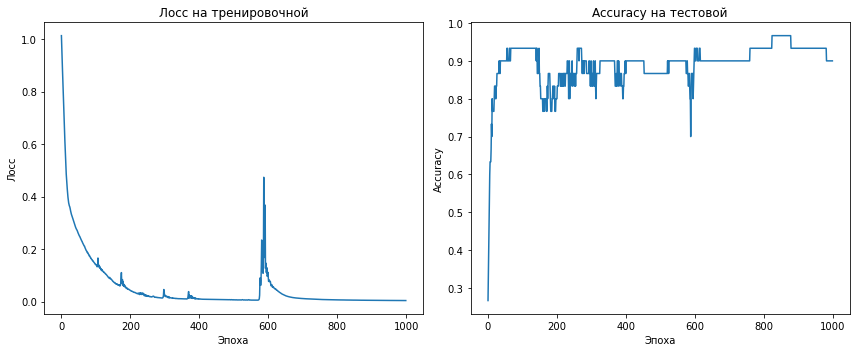

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_history = []
accuracy_history = []

# Тренировка
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train_tensor)
    loss = loss_fn(logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        _, preds = torch.max(test_preds, dim=1)
        acc = (preds == y_test_tensor).float().mean()

    train_loss_history.append(loss.item())
    accuracy_history.append(acc.item())

    if (epoch + 1) % 100 == 0:
        print(f"Эпоха {epoch + 1}: Train Loss = {loss.item():.4f}, Test Accuracy = {acc:.4f}")

# Графики обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Лосс")
plt.title("Лосс на тренировочной")
plt.xlabel("Эпоха")
plt.ylabel("Лосс")

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Accuracy")
plt.title("Accuracy на тестовой")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

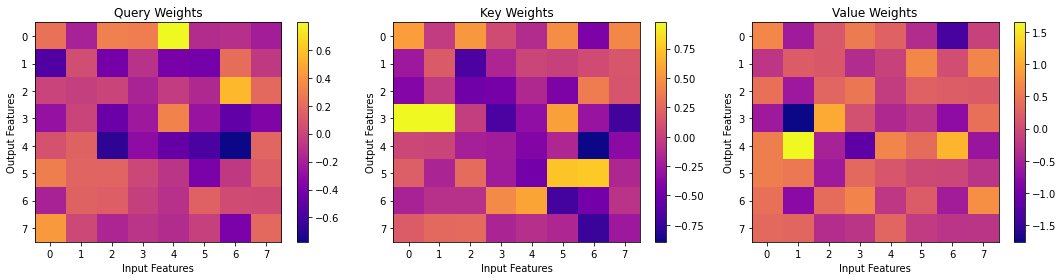

In [24]:
# Визуализация весов attention-блоков
def plot_attention_weights(net):
    mlstm = net.feature_extractor.layers[0]

    matrices = {
        'Query Weights': mlstm.Wq.blocks[0].weight.data.cpu().numpy(),
        'Key Weights': mlstm.Wk.blocks[0].weight.data.cpu().numpy(),
        'Value Weights': mlstm.Wv.blocks[0].weight.data.cpu().numpy()
    }

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for ax, (name, weight_matrix) in zip(axs, matrices.items()):
        im = ax.imshow(weight_matrix, cmap='plasma', aspect='auto')
        ax.set_title(name)
        ax.set_xlabel("Input Features")
        ax.set_ylabel("Output Features")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

plot_attention_weights(model)


## Анализ весов внимания

Wq (Query):
Наибольшие положительные значения наблюдаются в строках, соответствующих признакам 3, 6 и 7, что может указывать на повышенное внимание модели к этим характеристикам при генерации запросов. При этом в верхней части матрицы преобладают отрицательные значения, что, вероятно, отражает механизм подавления менее значимых признаков.

Wk (Key):
В центральной области матрицы заметны участки с ярко выраженными положительными и отрицательными значениями. Такая структура может свидетельствовать о том, что внимание модели формируется за счёт сложного взаимодействия признаков в середине векторного представления.

Wv (Value):
Положительные веса сконцентрированы преимущественно на признаках с нечётными индексами — 1, 3, 5 и 7. В то же время признаки 0, 2, 4 и 6 вносят отрицательный вклад. Это может означать, что при обновлении внутреннего состояния модель делает упор на информацию, закодированную в нечётных признаках.



## Сравнение с  Mambda
    
В рамках данного эксперимента LSTM показала себя менее эффективно, чем модель на базе Mamba. Последняя уверенно достигает полной точности (100%) на тестовой выборке, тогда как LSTM стабилизируется в диапазоне 80–90%, не превышая порог 93% даже при длительном обучении. Это указывает на более высокую выразительность или лучшую способность Mamba к адаптации под структуру признаков в датасете.